In [251]:
import geopandas as gpd
import pandas as pd
import sys
import os
import gtfs_kit as gtk
import numpy as np
sys.path.insert(0, r'../../../')
from quetzal.io.gtfs_reader import importer
from quetzal.io.gtfs_reader.frequencies import hhmmss_to_seconds_since_midnight 
from quetzal.model import stepmodel


import warnings
warnings.filterwarnings("ignore")

In [252]:
time_range = ['6:00:00', '8:59:00'] # PPAM
#dates = ['20191015'] # the dates must be within the feed start and end dates
#https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.weekday.html
day = 'tuesday'
day_dict = {
    'monday': 0,
    'tuesday': 1,
    'wednesday': 2,
    'thursday': 3,
    'friday': 4,
    'saturday': 5,
    'sunday': 6
}
selected_day = day_dict[day]
selected_day

1

In [253]:

files=['../tests/gtfs/brisbane.zip']
files=[      "https://storage.googleapis.com/storage/v1/b/mdb-latest/o/au-queensland-translink-south-east-queensland-translink-seq-gtfs-668.zip?alt=media"
]

In [254]:
#files = ["https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-british-columbia-translink-vancouver-gtfs-1222.zip?alt=media",'gtfs/cmm/stl.zip']
#files=['https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media']

# import

In [255]:
feeds=[]
for file in files:
    print('Importing {f}.zip'.format(f=file))
    feeds.append(importer.GtfsImporter(path=file, dist_units='m'))


Importing https://storage.googleapis.com/storage/v1/b/mdb-latest/o/au-queensland-translink-south-east-queensland-translink-seq-gtfs-668.zip?alt=media.zip


In [261]:
for i in range(len(feeds)):
    print(files[i])
    if 'agency_id' not in feeds[i].agency:
        print(f'add agency_id to agency in {files[i]}')
        feeds[i].agency['agency_id'] = feeds[i].agency['agency_name']
    
    if 'agency_id' not in feeds[i].routes:
        print(f'add agency_id to routes in {files[i]}')
        feeds[i].routes['agency_id'] = feeds[i].agency['agency_id'].values[0]
    
    if 'pickup_type' not in feeds[i].stop_times:
        print(f'picjup_type missing in stop_times. set to 0 in {files[i]}')
        feeds[i].stop_times['pickup_type'] = 0
    
    if 'drop_off_type' not in feeds[i].stop_times:
        print(f'drop_odd_type missing in stop_times. set to 0 in {files[i]}')
        feeds[i].stop_times['drop_off_type'] = 0
        
    if 'parent_station' not in feeds[i].stops:
        print(f'parent_station missing in stops. set to NaN in {files[i]}')
        feeds[i].stops['parent_station'] = np.nan
    if 'stop_code' not in feeds[i].stops:
        print(f'stop_code missing in stops. set to NaN in {files[i]}')
        feeds[i].stops['stop_code'] = np.nan
        
    feeds[i].stop_times['pickup_type'].fillna(0, inplace=True)
    feeds[i].stop_times['drop_off_type'].fillna(0, inplace=True)
    feeds[i].stop_times['arrival_time'] = feeds[i].stop_times['departure_time']

https://storage.googleapis.com/storage/v1/b/mdb-latest/o/au-queensland-translink-south-east-queensland-translink-seq-gtfs-668.zip?alt=media


In [262]:
feeds[0].agency

,agency_name,agency_url,agency_timezone,agency_lang,agency_phone,agency_id
0,Translink,https://translink.com.au/,Australia/Brisbane,en,13 12 30,Translink


In [263]:
feeds[0].trips

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id
0,R395-2410,ATS_MGB 24-35256,26730744-ATS_MGB 24-35256,Roma Street station,0,NaN,R3950114
1,R395-2410,ATS_MGB 24-35256,26730745-ATS_MGB 24-35256,Roma Street station,0,NaN,R3950114
2,R395-2410,ATS_MGB 24-35256,26730746-ATS_MGB 24-35256,Roma Street station,0,NaN,R3950114
3,R395-2410,ATS_MGB 24-35256,26730747-ATS_MGB 24-35256,Roma Street station,0,NaN,R3950114
4,R395-2410,ATS_MGB 24-35256,26730748-ATS_MGB 24-35256,Roma Street station,0,NaN,R3950114
...,...,...,...,...,...,...,...
124655,528-3072,WBS 23_24-33448,24312335-WBS 23_24-33448,Springfield station,0,NaN,5280049
124656,533-3072,WBS 23_24-33448,24312336-WBS 23_24-33448,Orion Springfield Central Anti-Clockwise,1,NaN,5330020
124657,527-3072,WBS 23_24-33448,24312337-WBS 23_24-33448,Orion Springfield Central,1,NaN,5270069
124658,526-3072,WBS 23_24-33448,24312338-WBS 23_24-33448,Springfield Central,1,NaN,5260042


# filtres

In [264]:
dates =[]
for feed in feeds:
    try:
        min_date = feed.calendar['start_date'].unique().min()
        max_date = feed.calendar['end_date'].unique().max()
    except:
        min_date = feed.calendar_dates['date'].unique().min()
        max_date = feed.calendar_dates['date'].unique().max()
        
    # get date range 
    s = pd.date_range(min_date, max_date, freq='D').to_series()
    try:
        # get dayofweek selected and take first one
        s = s[s.dt.dayofweek==selected_day][0]
        # format  ex: ['20231011'] and append
        dates.append([f'{s.year}{str(s.month).zfill(2)}{str(s.day).zfill(2)}'])
    except:
        print('date not available. use', min_date)
        dates.append(min_date)
        


In [265]:
dates
time_range

['6:00:00', '8:59:00']

In [266]:
feeds_t = []

for i, feed in enumerate(feeds):
    feed_t = feed.restrict(dates=dates[i], time_range=time_range)
    if len(feed_t.trips) > 0:
        feeds_t.append(feed_t)
    

In [267]:
feeds_t[0].shapes is None

False

In [268]:
type(feed.shapes) == type(None)

False

In [269]:
print('add shape_dist_traveled to shapes')
for feed in feeds_t:
    if feed.shapes is None:
        print('no shapes in gtfs')
        pass
    elif 'shape_dist_traveled' not in feed.shapes.columns:
        feed.append_dist_to_shapes()
    elif any(feed.shapes['shape_dist_traveled'].isnull()):
        feed.append_dist_to_shapes()

add shape_dist_traveled to shapes


In [270]:
for feed in feeds_t:
    if feed.shapes is None:
        print('no shapes in gtfs')
        continue
    elif 'shape_dist_traveled' not in feed.stop_times.columns:
        feed.append_dist_to_stop_times_fast()
    else:
        nan_sequence=feed.stop_times[feed.stop_times['shape_dist_traveled'].isnull()]['stop_sequence'].unique()
        if all(seq==1 for seq in nan_sequence):
            feed.stop_times['shape_dist_traveled'] = feed.stop_times['shape_dist_traveled'].fillna(0)
        else:
            feed.append_dist_to_stop_times_fast
            
    if feed.stop_times['shape_dist_traveled'].max() < 100:
        print(f'convert to meters')
        feed.dist_units = 'km'
        feed = gtk.convert_dist(feed, new_dist_units='m')


In [271]:
%%time
feeds_frequencies = []

for i in range(len(feeds_t)):
    print(i)
    feed_s = feeds_t[i].copy()
    feed_s.group_services()

    feed_s.build_stop_clusters(distance_threshold=50)
    feed_s.build_patterns(on='cluster_id')

    feed_frequencies = feed_s.convert_to_frequencies(time_range=time_range)
    shapes = feed_frequencies.shapes is not None
    feed_frequencies.build_links_and_nodes(log=False, 
                                           shape_dist_traveled=True, 
                                           from_shape=shapes, 
                                           stick_nodes_on_links=shapes,
                                           num_cores=4,
                                           keep_origin_columns=['departure_time','pickup_type'],
                                           keep_destination_columns=['arrival_time','drop_off_type'])
    feeds_frequencies.append(feed_frequencies)

0
CPU times: user 19.2 s, sys: 363 ms, total: 19.5 s
Wall time: 1min 46s


In [272]:
feeds_frequencies[0].links['headway']

11499    10740
23126     5370
23143     5370
13757     1534
19660    10740
         ...  
5010      5370
4922      5370
4923      5370
5011      5370
4924      5370
Name: headway, Length: 25366, dtype: int64

In [273]:
import json
with open('../route_type.json') as file:
    mapping = json.load(file)
    mapping = {int(key):item for key,item in mapping.items()}

In [274]:
retire = ['taxi']
for feed_frequencies in feeds_frequencies:
    feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
        lambda t: mapping.get(t, np.nan)
    )
    
    assert not any(feed_frequencies.links['route_type'].isna())
    feed_frequencies.links = feed_frequencies.links[~feed_frequencies.links['route_type'].isin(retire)]

for feed_frequencies in feeds_frequencies:
    feed_frequencies.links.loc[feed_frequencies.links['time'] == 0,'time'] = 1.0

# create Model

In [275]:
columns=['trip_id','route_id','agency_id','direction_id','a','b', 'shape_dist_traveled',
                                    'link_sequence','time','headway','pickup_type', 'drop_off_type',
                                    'route_short_name','route_type','route_color','geometry']

In [276]:
feeds_frequencies[0].links['headway']

11499    10740
23126     5370
23143     5370
13757     1534
19660    10740
         ...  
5010      5370
4922      5370
4923      5370
5011      5370
4924      5370
Name: headway, Length: 25366, dtype: int64

In [277]:
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='meter')

links_concat = []; nodes_concat = []
for feed_frequencies in feeds_frequencies:
    links_concat.append(feed_frequencies.links)
    nodes_concat.append(feed_frequencies.nodes)
if len(links_concat)==0:
    print('gg')
    
sm.links = pd.concat(links_concat)
for col in columns:
    if col not in sm.links.columns:
        sm.links[col] = np.nan
        
sm.links = sm.links[columns]
sm.nodes = pd.concat(nodes_concat)[['stop_id','stop_name','stop_code','geometry']]

sm.nodes = sm.nodes.reset_index(drop=True).sort_index()
sm.links = sm.links.reset_index(drop=True).sort_index()


sm.nodes.loc[sm.nodes['stop_code'].isna(),'stop_code'] = sm.nodes.loc[sm.nodes['stop_code'].isna(),'stop_id'] 
sm.nodes.drop_duplicates(subset=['stop_id'], inplace=True)

sm.links['trip_id'] = sm.links['agency_id'] +'_' +sm.links['trip_id']
sm.links['route_id'] = sm.links['agency_id'] +'_' +sm.links['route_id']

sm.links = sm.links.sort_values(['route_type','trip_id']).reset_index(drop=True)

dnodes = ('node_' +sm.nodes.reset_index().set_index('stop_id')['index'].astype(str)).to_dict()
sm.nodes.index = 'node_' +sm.nodes.index.astype(str)

sm.links.index = 'link_' +sm.links.index.astype(str)

sm.links['a'] = sm.links['a'].apply(lambda a: dnodes.get(a))
sm.links['b'] = sm.links['b'].apply(lambda a: dnodes.get(a))

sm.links.drop_duplicates(subset=['trip_id','link_sequence'], inplace=True)

# Tag route with only one trip
#time_slot = np.diff([hhmmss_to_seconds_since_midnight(time) for time in time_range])[0]
#sm.links.loc[(time_slot/sm.links['headway']) < 2.0, 'headway'] = np.nan

sm.links = sm.links.to_crs(4326)
sm.nodes = sm.nodes.to_crs(4326)

In [278]:
gpd.GeoDataFrame(columns=['feature'], geometry='feature',crs=4326).to_file('test.geojson',driver='GeoJSON')

# test

In [279]:
len(sm.links['trip_id'].unique())

896

<Axes: >

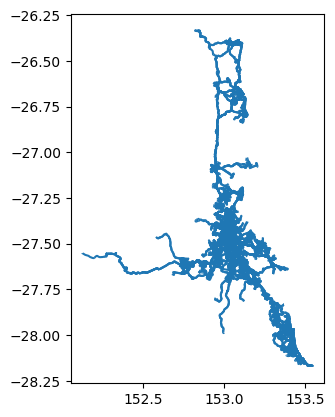

In [281]:
sm.links.plot()

In [19]:
# lambda price for 10GB per hours
price = 0.0000166667*60*60*10
price

0.6000012

In [20]:
price*20

12.000024

In [21]:
400_000/60/60/10 #heures gratuites a 10gb.

11.11111111111111

In [22]:
# with EB EC2 t3.xlarge:
# 4 cores,m 16bg
price = 0.1856 #per hour

In [23]:
price*30

5.568

In [ ]:
#plan de match:
si on a pas de shape_dist_traveled. prendre le temps avec les stop_time comme dist.
(la methode 2 de gtfs_kit quand ca marche pas)

anyway. on va recalculer avec le shape avec la methode a simon f.

In [202]:
test

<function __main__.parallel.<locals>.decorator.<locals>.wrapper(*args, **kwargs)>

In [271]:
from parallel import parallel

In [424]:
from multiprocessing import Process, Manager

def parallel(loop_arg,num_cores=2):
    def decorator(func):
        def wrapper(**kwargs):
            print(num_cores)
            if num_cores==1:
                return func(**kwargs)
            else:
                ls = kwargs.pop(loop_arg)
                chunk_length =  round(len(ls)/ num_cores)
                chunks = [ls[j: j + chunk_length] for j in range(0, len(ls), chunk_length)]
                
                def process_wrapper(chunk, kwargs, result_list, index):
                    kwargs[loop_arg] = chunk
                    result = func(**kwargs)
                    result_list[index] = result
                manager = Manager()
                result_list = manager.list([None] * len(chunks))
                processes = []
                for i, chunk in enumerate(chunks):
                    process = Process(target=process_wrapper, args=(chunk, kwargs, result_list, i))
                    process.start()
                    processes.append(process)
                for process in processes:
                    process.join()
                # Convert the manager list to a regular list for easier access
                result_list = np.array(result_list)
                if result_list.ndim==1:
                    return result_list
                else:
                    tuple_len = result_list.shape[1]
                    return tuple(res[:][i] for i in range(tuple_len))
                 
        return wrapper
    return decorator





In [425]:
@parallel(num_cores=2,loop_arg='trip_list')
def test(links,trip_list,constant):
    result = []
    for trip in trip_list:
        links = sm.links[sm.links['trip_id']==trip]
        res = links['headway'].values.sum() + constant
        result.append((trip,res))
    return result,'yes'

In [426]:
trip_list =  sm.links['trip_id'].unique()
# calling the function
res1,res2 = test(links=sm.links, trip_list=trip_list, constant=44)

2


In [413]:
res.shape[1]

2

In [ ]:
def plot_tasks(tasks,col=None,time_range=[],colors=['dodgerblue','tab:blue','cadetblue','darkturquoise','powderblue']):
    # start_time, 'time','index'
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib.colors import ColorConverter
    f, ax = plt.subplots(figsize=(15,12))
    w=0.8
    if 'index' not in tasks.columns:
        tasks = tasks.reset_index()
    if col:
        tasks = tasks.sort_values(col)
        line_ids = tasks[col].unique()
        
        for i,line_id in enumerate(tasks[col].unique()):
            task = tasks[tasks[col]==line_id]
            ax.barh(task['index'],task['time'],height=w , left=task['start_time'],color=colors[i])
            
        legend_elements = [Line2D([0], [0], color=colors[i], lw=4, label=line_ids[i]) for i in range(len(line_ids))]

        ax.legend(handles=legend_elements,prop={"size":16})
    else:
        ax.barh(tasks['index'],tasks['time'],height=w , left=tasks['start_time'])
            # y position (bus number) ,   #length (task duration),   height ,           x position (start_time)


    plt.xlabel('time')
    plt.ylabel('trip number')

    ##### labels ####
    if len(time_range)>0:
        plt.axvline(x = time_range[0], color = 'r', label = 'axvline - full height')
        plt.axvline(x = time_range[1], color = 'r', label = 'axvline - full height')


    ##### TICKS #####
    start_tick = int(np.floor(tasks['start_time'].min()/60/60)*60*60-60*60)
    end_tick = int(np.ceil(tasks['end_time'].max()/60/60)*60*60)

    xticks = np.arange(start_tick,end_tick,3600)
    xticks_minor = np.arange(start_tick,end_tick,3600/2)

    xticks_labels = xticks//3600
    xticks_labels[xticks_labels>=24] = xticks_labels[xticks_labels>=24]-24
    xticks_labels = [str(x)+'H00' for x in xticks_labels]


    ax.set_xticks(xticks)
    ax.set_xticks(xticks_minor, minor=True)
    ax.set_xticklabels(xticks_labels)

    plt.show()

In [ ]:
%%time
time_range=['6:00:00', '9:59:00']
feed = feeds[1].copy()
feed = feed.restrict(['20190625'],time_range=time_range)
res = feed.stop_times.groupby('trip_id')['departure_time'].agg(['first','last']).sort_values('first')
res

In [ ]:


res['start_time']=res['first'].apply(lambda x : hhmmss_to_seconds_since_midnight(x))
res['end_time']=res['last'].apply(lambda x : hhmmss_to_seconds_since_midnight(x))
res['time'] = res['end_time'] - res['start_time']
plot_tasks(res.reset_index(),time_range=[hhmmss_to_seconds_since_midnight(x) for x in time_range])

In [133]:
self = feeds_t[0].copy()
self.append_dist_to_shapes()

In [106]:
from pyproj import transform
self = feeds_t[0].copy()
epsg = importer.get_epsg(self.stops.iloc[1]['stop_lat'], self.stops.iloc[1]['stop_lon'])
self.shapes['shape_pt_x'],self.shapes['shape_pt_y'] = transform(4326, epsg, self.shapes['shape_pt_lat'],self.shapes['shape_pt_lon'])
#get distance between each points
self.shapes = self.shapes.sort_values(['shape_id','shape_pt_sequence']).reset_index(drop=True)
self.shapes['geom'] = self.shapes[['shape_pt_y','shape_pt_x']].apply(tuple,axis=1)
self.shapes['previous_geom'] = self.shapes['geom'].shift(+1).fillna(method='bfill')


self.shapes['dist'] = self.shapes[['previous_geom','geom']].apply(lambda x: importer.euclidean_distance(x[0],x[1]), axis=1)
# cumsum the dist minus the first one (should be 0 but its not due to the batch operation)
self.shapes['shape_dist_traveled'] = self.shapes.groupby('shape_id')['dist'].apply(importer.cumulative_minus_first)
self.shapes = self.shapes.drop(columns=['shape_pt_x','shape_pt_y','geom','previous_geom','dist'])
if self.dist_units == 'km':
    self.shapes['shape_dist_traveled'] = self.shapes['shape_dist_traveled']/1000

In [112]:
self.shapes.dropna()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,396,48.39229,-77.24439,1,0.000000
1,396,48.39146,-77.24048,2,303.902648
2,396,48.39090,-77.23902,3,428.670935
3,396,48.39014,-77.23789,4,547.599337
4,396,48.38935,-77.23723,5,648.123082
...,...,...,...,...,...
13824,554,45.44828,-73.73928,65,4875.375400
13825,554,45.44855,-73.74083,66,5000.253877
13826,554,45.44865,-73.74096,67,5015.314400
13827,554,45.44866,-73.74127,68,5039.584048


In [134]:
self.shapes[self.shapes['shape_dist_traveled'].isnull()]

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled


In [115]:
files=['https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media'] 
start_time='6:00:00' 
end_time='8:59:00' 
day='tuesday' 
dates=[]

DAY_DICT = {
    'monday': 0,
    'tuesday': 1,
    'wednesday': 2,
    'thursday': 3,
    'friday': 4,
    'saturday': 5,
    'sunday': 6
}

In [117]:


selected_day = DAY_DICT[day]
time_range = [start_time,end_time]


feeds=[]
for file in files:
    print('Importing {f}'.format(f=file))
    feeds.append(importer.GtfsImporter(path=file, dist_units='m'))


for i in range(len(feeds)):
    print('cleaning ', files[i])
    if 'agency_id' not in feeds[i].routes:
        print(f'add agency_id to routes in {files[i]}')
        feeds[i].routes['agency_id'] = feeds[i].agency['agency_id'].values[0]

    if 'pickup_type' not in feeds[i].stop_times:
        print(f'pickup_type missing in stop_times. set to 0 in {files[i]}')
        feeds[i].stop_times['pickup_type'] = 0

    if 'drop_off_type' not in feeds[i].stop_times:
        print(f'drop_off_type missing in stop_times. set to 0 in {files[i]}')
        feeds[i].stop_times['drop_off_type'] = 0

    if 'parent_station' not in feeds[i].stops:
        print(f'parent_station missing in stops. set to NaN in {files[i]}')
        feeds[i].stops['parent_station'] = np.nan
    feeds[i].stop_times['pickup_type'].fillna(0, inplace=True)
    feeds[i].stop_times['drop_off_type'].fillna(0, inplace=True)

    feeds[i].stop_times['arrival_time'] = feeds[i].stop_times['departure_time']

# if dates is not provided as inputs.
# get it from first dates of each GTFS
if len(dates)==0:
    for feed in feeds:
        try:
            min_date = feed.calendar['start_date'].unique().min()
            max_date = feed.calendar['end_date'].unique().max()
        except:
            min_date = feed.calendar_dates['date'].unique().min()
            max_date = feed.calendar_dates['date'].unique().max()

        # get date range 
        s = pd.date_range(min_date, max_date, freq='D').to_series()
        try:
            # get dayofweek selected and take first one
            s = s[s.dt.dayofweek==selected_day][0]
            # format  ex: ['20231011'] and append
            dates.append(f'{s.year}{str(s.month).zfill(2)}{str(s.day).zfill(2)}')
        except:
            print('date not available. use', min_date)
            dates.append(min_date)




Importing https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media
cleaning  https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media
parent_station missing in stops. set to NaN in https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media


In [119]:
dates

['20231107']

In [120]:
feeds_t = []
print('restrict feed')
for i, feed in enumerate(feeds):
    feed_t = feed.restrict(dates=[dates[i]], time_range=time_range)
    #if len(feed_t.trips) > 0:
    feeds_t.append(feed_t)

restrict feed


In [121]:
dates

['20231107']

In [122]:
feeds_t = []
print('restrict feed')
for i, feed in enumerate(feeds):
    feed_t = feed.restrict(dates=[dates[i]], time_range=time_range)
    if len(feed_t.trips) > 0:
        feeds_t.append(feed_t)
#del feeds
print('add shape_dist_traveled to shapes')
for feed in feeds_t:
    if 'shape_dist_traveled' not in feed.shapes.columns:
        feed.append_dist_to_shapes()
    elif any(feed.shapes['shape_dist_traveled'].isnull()):
        feed.append_dist_to_shapes()

print('add shape_dist_traveled to stop_times')
for feed in feeds_t:
    if 'shape_dist_traveled' not in feed.stop_times.columns:
        feed.append_dist_to_stop_times_fast()
    else:
        nan_sequence=feed.stop_times[feed.stop_times['shape_dist_traveled'].isnull()]['stop_sequence'].unique()
        # if there but all nan are at seq=1. just fill wwith 0.
        if all(seq==1 for seq in nan_sequence):
            feed.stop_times['shape_dist_traveled'] = feed.stop_times['shape_dist_traveled'].fillna(0)
        else:
            feed.append_dist_to_stop_times_fast()
print('convert to meter if necessary')
for feed in feeds_t:
    if feed.stop_times['shape_dist_traveled'].max() < 100:
            print(f'convert to meters')
            feed.dist_units = 'km'
            feed = gtk.convert_dist(feed, new_dist_units='m')

feeds_frequencies = []
for i in range(len(feeds_t)):
    print('Building links and nodes ', files[i])
    feed_s = feeds_t[i].copy()
    feed_s.group_services()

    feed_s.build_stop_clusters(distance_threshold=50)
    feed_s.build_patterns(on='cluster_id')

    feed_frequencies = feed_s.convert_to_frequencies(time_range=time_range)
    shapes = feed_frequencies.shapes is not None
    feed_frequencies.build_links_and_nodes(log=False, 
                                        shape_dist_traveled=True, 
                                        from_shape=shapes, 
                                        stick_nodes_on_links=shapes,
                                        keep_origin_columns=['departure_time','pickup_type'],
                                        keep_destination_columns=['arrival_time','drop_off_type'],
                                        num_cores=4)
    feeds_frequencies.append(feed_frequencies)


restrict feed
add shape_dist_traveled to shapes
add shape_dist_traveled to stop_times
convert to meter if necessary
Building links and nodes  https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media


In [123]:
#del feeds_t
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',4:'ferry',5:'cable_car',6:'gondola',7:'funicular', 700:'bus', 1501:'taxi'}
retire = ['taxi']
for feed_frequencies in feeds_frequencies:
    feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
        lambda t: mapping.get(t, np.nan)
    )

    assert not any(feed_frequencies.links['route_type'].isna())
    feed_frequencies.links = feed_frequencies.links[~feed_frequencies.links['route_type'].isin(retire)]

for feed_frequencies in feeds_frequencies:
    feed_frequencies.links.loc[feed_frequencies.links['time'] == 0,'time'] = 1.0



columns=['trip_id','route_id','agency_id','direction_id','a','b', 'shape_dist_traveled',
                                    'link_sequence','time','headway','pickup_type', 'drop_off_type',
                                    'route_short_name','route_type','route_color','geometry']


sm = stepmodel.StepModel(epsg=4326, coordinates_unit='meter')

links_concat = []; nodes_concat = []
for feed_frequencies in feeds_frequencies:
    links_concat.append(feed_frequencies.links)
    nodes_concat.append(feed_frequencies.nodes)

In [124]:
feeds_frequencies

In [66]:


# nothing to export. export empty geojson
if len(links_concat) == 0:
    links = gpd.GeoDataFrame(columns=['feature'], geometry='feature',crs=4326)
    nodes = gpd.GeoDataFrame(columns=['feature'], geometry='feature',crs=4326)
    return

sm.links = pd.concat(links_concat)
for col in columns:
    if col not in sm.links.columns:
        sm.links[col] = np.nan

sm.links = sm.links[columns]
sm.nodes = pd.concat(nodes_concat)[['stop_id','stop_name','stop_code','geometry']]

sm.nodes = sm.nodes.reset_index(drop=True).sort_index()
sm.links = sm.links.reset_index(drop=True).sort_index()


sm.nodes.loc[sm.nodes['stop_code'].isna(),'stop_code'] = sm.nodes.loc[sm.nodes['stop_code'].isna(),'stop_id'] 
sm.nodes.drop_duplicates(subset=['stop_id'], inplace=True)

sm.links['trip_id'] = sm.links['agency_id'] +'_' +sm.links['trip_id']
sm.links['route_id'] = sm.links['agency_id'] +'_' +sm.links['route_id']

sm.links = sm.links.sort_values(['route_type','trip_id']).reset_index(drop=True)

dnodes = ('node_' +sm.nodes.reset_index().set_index('stop_id')['index'].astype(str)).to_dict()
sm.nodes.index = 'node_' +sm.nodes.index.astype(str)

sm.links.index = 'link_' +sm.links.index.astype(str)

sm.links['a'] = sm.links['a'].apply(lambda a: dnodes.get(a))
sm.links['b'] = sm.links['b'].apply(lambda a: dnodes.get(a))

sm.links.drop_duplicates(subset=['trip_id','link_sequence'], inplace=True)

# Tag route with only one trip
time_slot = np.diff([hhmmss_to_seconds_since_midnight(time) for time in time_range])[0]
sm.links.loc[(time_slot/sm.links['headway']) < 2.0, 'headway'] = np.nan

sm.links = sm.links.to_crs(4326)
sm.nodes = sm.nodes.to_crs(4326)

Importing https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media
cleaning  https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media
parent_station missing in stops. set to NaN in https://storage.googleapis.com/storage/v1/b/mdb-latest/o/ca-quebec-reseau-de-transport-de-la-capitale-gtfs-757.zip?alt=media
restrict feed
add shape_dist_traveled to shapes
add shape_dist_traveled to stop_times
convert to meter if necessary


SyntaxError: 'return' outside function (1528547802.py, line 141)

In [72]:
pd.read_csv('route_type.csv').set_index('a')['b'].to_json('route_type.json')

In [80]:
df = pd.read_csv('route_type.csv')
df.dtypes

a     int64
b    object
dtype: object

In [74]:
import json
with open('route_type.json') as file:
    data = json.load(file)

In [75]:
data

{'100': 'Railway Service ',
 '101': 'High Speed Rail Service ',
 '102': 'Long Distance Trains ',
 '103': 'Inter Regional Rail Service ',
 '104': 'Car Transport Rail Service ',
 '105': 'Sleeper Rail Service ',
 '106': 'Regional Rail Service ',
 '107': 'Tourist Railway Service ',
 '108': 'Rail Shuttle (Within Complex) ',
 '109': 'Suburban Railway ',
 '110': 'Replacement Rail Service ',
 '111': 'Special Rail Service ',
 '112': 'Lorry Transport Rail Service ',
 '113': 'All Rail Services ',
 '114': 'Cross-Country Rail Service ',
 '115': 'Vehicle Transport Rail Service ',
 '116': 'Rack and Pinion Railway ',
 '117': 'Additional Rail Service ',
 '200': 'Coach Service ',
 '201': 'International Coach Service ',
 '202': 'National Coach Service ',
 '203': 'Shuttle Coach Service ',
 '204': 'Regional Coach Service ',
 '205': 'Special Coach Service ',
 '206': 'Sightseeing Coach Service ',
 '207': 'Tourist Coach Service ',
 '208': 'Commuter Coach Service ',
 '209': 'All Coach Services ',
 '400': 'Urba